In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import pickle

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [2]:
heart_data = "../data/clean/resampled_data.csv"
heart_df = pd.read_csv(heart_data)
heart_df = heart_df.drop(columns=['Unnamed: 0'], axis=1)

In [3]:
# Performing train split 

target = heart_df['HeartDiseaseorAttack']
features = heart_df.drop('HeartDiseaseorAttack', axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [4]:
#Normalise all columns to be 0-1
normalizer = MinMaxScaler()
normalizer.fit(x_train)

x_train_norm = normalizer.transform(x_train)
x_test_norm = normalizer.transform(x_test)

x_train_norm_df = pd.DataFrame(x_train_norm, columns=x_train.columns, index=x_train.index )
x_test_norm_df = pd.DataFrame(x_test_norm, columns=x_test.columns, index=x_test.index)

### Random Forests:

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train_norm_df, y_train)
y_pred_rf = rf.predict(x_test_norm_df)

### Gradient Boosting:

In [6]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=100, random_state=0)  
model.fit(x_train_norm_df, y_train)
y_pred_xgb = model.predict(x_test_norm_df)

### Adaptive Boosting:

In [7]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators=100, random_state=0)
ab.fit(x_train_norm_df, y_train)
y_pred_ab = ab.predict(x_test_norm_df)

/opt/anaconda3/envs/base_new/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Voting:

In [8]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

model1 = RandomForestClassifier(n_estimators=100, random_state=0)
model2 = xgb.XGBClassifier(n_estimators=100, random_state=0)
model3 = LogisticRegression()

ensemble_model = VotingClassifier(estimators=[
    ('rf', model1), ('xgb', model2), ('lr', model3)],
    voting='hard')  # 'hard' for majority class voting, 'soft' for class probabilities

ensemble_model.fit(x_train_norm_df, y_train)
y_pred_ensemble = ensemble_model.predict(x_test_norm_df)

### Accuracy:

In [9]:
from sklearn.metrics import accuracy_score, r2_score

print(f'Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf)}')
print(f'Accuracy (XGBoost): {accuracy_score(y_test, y_pred_xgb)}')
print(f'Accuracy (AdaBoost): {accuracy_score(y_test, y_pred_ab)}')

Accuracy (Random Forest): 0.7662690939527098
Accuracy (XGBoost): 0.7698263234986399
Accuracy (AdaBoost): 0.775162167817535


### Cross validation:

In [10]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf, x_train_norm_df, y_train, cv=5)
print(f'Random Forest Cross-Validation Score: {cv_scores_rf.mean()}')

# Cross-validation for XGBoost
cv_scores_xgb = cross_val_score(model, x_train_norm_df, y_train, cv=5)
print(f'XGBoost Cross-Validation Score: {cv_scores_xgb.mean()}')

Random Forest Cross-Validation Score: 0.758527972666216
XGBoost Cross-Validation Score: 0.763890530739986


### Confusion matrix:

In [11]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f'Confusion Matrix (Random Forest):\n {cm_rf}')
print(f'Confusion Matrix (XGBoost):\n {cm_xgb}')

Confusion Matrix (Random Forest):
 [[3503 1289]
 [ 945 3821]]
Confusion Matrix (XGBoost):
 [[3509 1283]
 [ 917 3849]]


### Receiver Operating Characteristic Area Under the Curve:

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_rf = roc_auc_score(y_test, rf.predict_proba(x_test_norm_df)[:, 1])
auc_xgb = roc_auc_score(y_test, model.predict_proba(x_test_norm_df)[:, 1])

print(f'AUC (Random Forest): {auc_rf}')
print(f'AUC (XGBoost): {auc_xgb}')

AUC (Random Forest): 0.8369585806039861
AUC (XGBoost): 0.8475946193368862


### Visualizations:

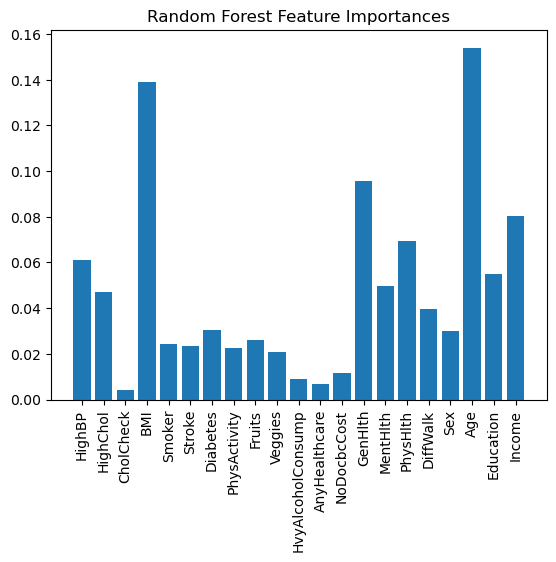

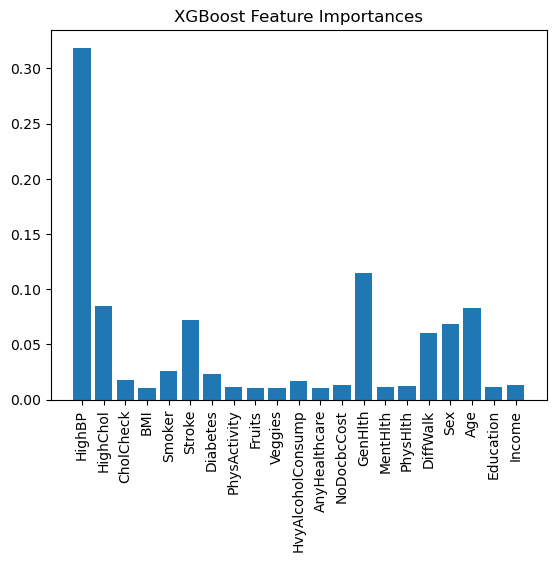

In [13]:
import matplotlib.pyplot as plt

feature_importances_rf = rf.feature_importances_
plt.bar(x_train_norm_df.columns, feature_importances_rf)
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importances')
plt.show()

feature_importances_xgb = model.feature_importances_
plt.bar(x_train_norm_df.columns, feature_importances_xgb)
plt.xticks(rotation=90)
plt.title('XGBoost Feature Importances')
plt.show()

### The best model is Gradient Boosting, because slightly outperforms in cross-validation (0.7650) and AUC (0.8473), which are often considered better indicators of overall model performance and generalizability. However, Adaptive Boosting (accuracy= 0.7740) is also a strong contender and could be preferred in certain situations where interpretability or avoiding overfitting is more important.¶